In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import numpy as np
import threading
import collections
import datetime
from nats.aio.client import Client as Nats
import json
import os
from dotenv import load_dotenv
from pathlib import Path


# Enable interactive plot
%matplotlib widget
%config InlineBackend.figure_format = 'retina'

In [3]:
# Load config file
dotenv_path = Path('..')
load_dotenv()

# Load nats server from environment variable
NATS_SERVER = os.getenv("NATS_SERVER", "tls://connect.ngs.global:4222")

# Configurations for network
NATS_CREDS_PATH="../natsEndpoint.creds"
EXPORT_SUBJECT = "EXPORT.acceleration"

# Configurations for plotting
PLOTTED_TIME_SEC = 10.0
NUMBER_OF_GRAPHS = 6

In [4]:
# Gloabal variables
# store received data for plotting
plot_data = collections.defaultdict(list)
plot_time_sec = []
plot_time_datetime = []

# Initialize arrays
plot_data['sensor1 x'].append(0.0)
plot_data['sensor1 y'].append(0.0)
plot_data['sensor1 z'].append(0.0)
plot_data['sensor2 x'].append(0.0)
plot_data['sensor2 y'].append(0.0)
plot_data['sensor2 z'].append(0.0)
plot_time_sec.append(0.0)
plot_time_datetime.append(datetime.datetime.now())

# Ensure to only plot complete written data
mutex = threading.Lock()

In [5]:
# Helper functions for data receiving
async def msg_handler(msg):
    global mutex, plot_data, plot_time_sec, plot_time_datetime
    msg_data = json.loads(msg.data.decode())["data"]
    
    lastt = plot_time_sec[-1]
    if lastt > plot_time_sec[0] + PLOTTED_TIME_SEC:  
        # reset the arrays
        mutex.acquire()
        plot_time_sec = [plot_time_sec[-1]]
        plot_time_datetime = [plot_time_datetime[-1]]
        plot_data['sensor1 x'] = [plot_data['sensor1 x'][-1]]
        plot_data['sensor1 y'] = [plot_data['sensor1 y'][-1]]
        plot_data['sensor1 z'] = [plot_data['sensor1 z'][-1]]
        plot_data['sensor2 x'] = [plot_data['sensor2 x'][-1]]
        plot_data['sensor2 y'] = [plot_data['sensor2 y'][-1]]
        plot_data['sensor2 z'] = [plot_data['sensor2 z'][-1]]
        mutex.release()

    # Add new data to data array
    mutex.acquire()
    plot_data['sensor1 x'].append(msg_data["sensor1"]["x"])
    plot_data['sensor1 y'].append(msg_data["sensor1"]["y"])
    plot_data['sensor1 z'].append(msg_data["sensor1"]["z"])
    plot_data['sensor2 x'].append(msg_data["sensor2"]["x"])
    plot_data['sensor2 y'].append(msg_data["sensor2"]["y"])
    plot_data['sensor2 z'].append(msg_data["sensor2"]["z"])
    plot_time_sec.append(float(msg_data["timestamp_ms"])/1000.0)
    plot_time_datetime.append(datetime.datetime.fromtimestamp(int(msg_data["timestamp_ms"])/1000.0))

    mutex.release()

async def connect_to_nats():
    # NATS connection options
    options = {
        "servers": [NATS_SERVER],
        "ping_interval": 1,
        "max_outstanding_pings": 5,
        "user_credentials": NATS_CREDS_PATH,
        "max_reconnect_attempts": 10,
    }
    
    nc = Nats()
    try:
        await nc.connect(**options)
    except Exception as e:
        print("Error connecting to NATS server: %s", e)
        exit

    return nc

In [6]:
# Class for plotting live data
class Scope:
    def __init__(self, ax):
        global mutex, plot_data, plot_time_datetime
        self.ax = ax
        mutex.acquire()
        self.line =  [Line2D(plot_time_datetime, plot_data['sensor1 x']), 
                      Line2D(plot_time_datetime, plot_data['sensor1 y']), 
                      Line2D(plot_time_datetime, plot_data['sensor1 z']),
                      Line2D(plot_time_datetime, plot_data['sensor2 x']),
                      Line2D(plot_time_datetime, plot_data['sensor2 y']),
                      Line2D(plot_time_datetime, plot_data['sensor2 z'])]
        mutex.release()
        for i in range(len(self.ax)):
            self.ax[i].add_line(self.line[i])
            self.ax[i].set_ylim(-.1, 10)
            self.ax[i].set_xlim(0, PLOTTED_TIME_SEC)
        ax[0].set_title('Sensor 1 X-Axis')
        ax[1].set_title('Sensor 1 Y-Axis')
        ax[2].set_title('Sensor 1 Z-Axis')
        ax[3].set_title('Sensor 2 X-Axis')
        ax[4].set_title('Sensor 2 Y-Axis')
        ax[5].set_title('Sensor 2 Z-Axis')
        self.xlim_start = 0

    def update(self, t):
        global mutex, plot_data, plot_time_sec, plot_time_datetime
        
        mutex.acquire()
        if self.xlim_start is not plot_time_datetime[0]:  # correct x axis
            self.xlim_start = plot_time_datetime[0]
            endDateTime = datetime.datetime.fromtimestamp(plot_time_sec[0] + PLOTTED_TIME_SEC)
            self.ax[0].set_xlim(plot_time_datetime[0], endDateTime)

        self.line[0].set_data(plot_time_datetime, plot_data['sensor1 x'])
        self.line[1].set_data(plot_time_datetime, plot_data['sensor1 y'])
        self.line[2].set_data(plot_time_datetime, plot_data['sensor1 z'])
        self.line[3].set_data(plot_time_datetime, plot_data['sensor2 x'])
        self.line[4].set_data(plot_time_datetime, plot_data['sensor2 y'])
        self.line[5].set_data(plot_time_datetime, plot_data['sensor2 z'])
        mutex.release()
        return self.line,

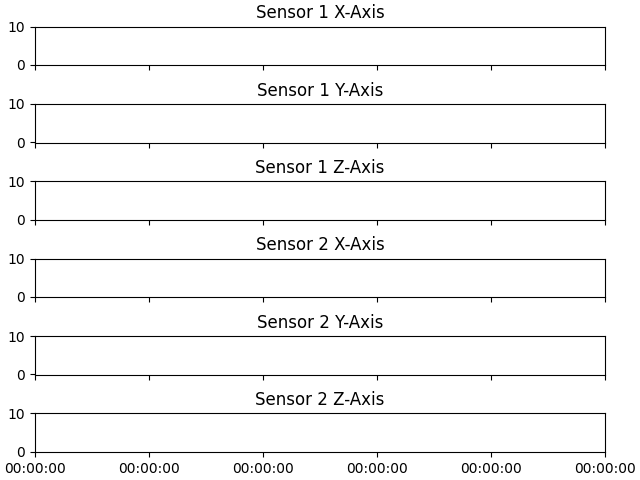

In [7]:
# Startup function
async def main():
    # Connect to NATS server to enable data reception
    nc = await connect_to_nats()

    # Subscribe to data endpoint
    sub = await nc.subscribe(EXPORT_SUBJECT, cb=msg_handler)

    # Prepare figure    
    fig, ax = plt.subplots(NUMBER_OF_GRAPHS, sharex=True, constrained_layout=True)
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
    scope = Scope(ax)
    
    # Create animation using the animate() function
    myAnimation = animation.FuncAnimation(fig, scope.update, frames=np.arange(start=0, stop=20000, step=200), \
                                      interval=200, blit=True, repeat=True)

    plt.show()
    
await main()